# 基于RTMPose的耳朵穴位关键点检测

## 训练RTMDet耳朵目标检测算法

In [ ]:
import os
os.chdir('mmdetection')

In [ ]:
!python tools/train.py data/rtmdet_tiny_ear.py

## 测试集评估模型精度

In [ ]:
python tools/test.py data/rtmdet_tiny_ear.py \
                      work_dirs/rtmdet_tiny_ear/epoch_200.pth

![rtmdet_result](pic/rtmdet_tiny_ear_result.png)

## 模型轻量化转换

In [ ]:
# RTMDet-tiny
!python tools/model_converters/publish_model.py \
        work_dirs/rtmdet_tiny_ear/epoch_200.pth \
        checkpoint/rtmdet_tiny_ear_epoch_200_20230604.pth

## 训练RTMPose耳朵关键点检测算法

In [ ]:
import os
os.chdir('mmpose')

In [ ]:
!python tools/train.py data/rtmpose-s-ear.py

## 测试集评估模型精度

In [ ]:
python tools/test.py data/rtmpose-s-ear.py \
                      work_dirs/rtmpose-s-ear/epoch_300.pth

![rtmpose_result](pic/rtmpose_tiny_ear_result.png)

## 关键点检测预测

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/ear.jpg'

In [5]:
# Image.open(img_path)

## 准备好的模型文件

In [6]:
## 目标检测模型

# Faster R CNN
# data/faster_r_cnn_triangle.py
# checkpoint/faster_r_cnn_triangle_epoch_50_202305120846-76d9dde3.pth

# RTMDet-Tiny
# data/rtmdet_tiny_triangle.py
# checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth

## 关键点检测模型

# data/rtmpose-s-triangle.py
# checkpoint/rtmpose-s-triangle-300-32642023_20230524.pth

## 构建目标检测模型

In [7]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_ear.py',
    'checkpoint/rtmdet_tiny_ear_epoch_200_20230604-0fba1521.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_ear_epoch_200_20230604-0fba1521.pth


## 构建关键点检测模型

In [8]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s-ear.py',
    'checkpoint/rtmpose-s-triangle-300_202300604.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose-s-triangle-300_202300604.pth


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/04 19:44:51 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
detect_result.keys()

['ignored_instances', 'pred_instances', 'gt_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.8999, 0.0474, 0.0352, 0.0317, 0.0263, 0.0243, 0.0240, 0.0226, 0.0211,
        0.0207, 0.0182, 0.0157, 0.0155, 0.0144, 0.0143, 0.0137, 0.0136, 0.0132,
        0.0131, 0.0128, 0.0119, 0.0109, 0.0104, 0.0100, 0.0100, 0.0096, 0.0094,
        0.0090, 0.0089, 0.0089, 0.0089, 0.0088, 0.0088, 0.0088, 0.0088, 0.0088,
        0.0087, 0.0086, 0.0082, 0.0081, 0.0081, 0.0079, 0.0079, 0.0079, 0.0079,
        0.0078, 0.0078, 0.0076, 0.0075, 0.0075, 0.0075, 0.0074, 0.0074, 0.0073,
        0.0073, 0.0072, 0.0072, 0.0072, 0.0072, 0.0071, 0.0071, 0.0071, 0.0071,
        0.0071, 0.0071, 0.0070, 0.0070, 0.0069, 0.0069, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0067, 0.0067, 0.0066, 0.0064, 0.0064, 0.0063, 0.0063, 0.0063,
        0.0062, 0.0062, 0.0062, 0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0057, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0055, 0.0055,
        0.0055, 0.0054, 0.0053, 0.0053, 0.0053, 0.0053, 0.0052, 0.0052, 0.0052,
        0.0051, 0.0051, 0.0051, 0.0051, 

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [17]:
bboxes

array([[1112,    7, 1669,  905]])

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

06/04 19:44:53 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/code/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [19]:
len(pose_results)

1

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['_pred_heatmaps', 'pred_instances', 'pred_fields', 'gt_instances']

## 预测结果-关键点坐标

In [22]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [23]:
keypoints

array([[[1263,  559],
        [1392,   46],
        [1427,  449],
        [1318,  736],
        [1331,  451],
        [1429,  412],
        [1357,  602],
        [1344,  563],
        [1383,  548],
        [1322,  605],
        [1322,  311],
        [1438,  493],
        [1335,  217],
        [1386,  195],
        [1366,  337],
        [1195,  383],
        [1166,  561],
        [1164,  751],
        [1519,  513],
        [1318,  795],
        [1456,  295]]])

In [24]:
keypoints.shape

(1, 21, 2)

In [25]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[1263,  559],
       [1392,   46],
       [1427,  449],
       [1318,  736],
       [1331,  451],
       [1429,  412],
       [1357,  602],
       [1344,  563],
       [1383,  548],
       [1322,  605],
       [1322,  311],
       [1438,  493],
       [1335,  217],
       [1386,  195],
       [1366,  337],
       [1195,  383],
       [1166,  561],
       [1164,  751],
       [1519,  513],
       [1318,  795],
       [1456,  295]])

## 预测结果-关键点热力图

In [26]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(21, 1414, 2121)

In [27]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [28]:
heatmap.shape

(1414, 2121)

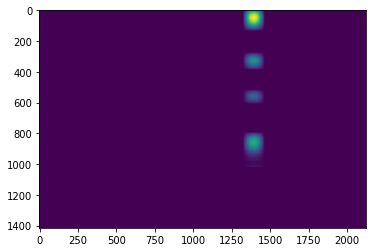

In [29]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [30]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 5
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

06/04 19:44:54 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [31]:
# 元数据
# pose_estimator.dataset_meta

In [35]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='output/ear_output.jpg',
            kpt_thr=0.3
)

In [36]:
img_output.shape

(2828, 2121, 3)

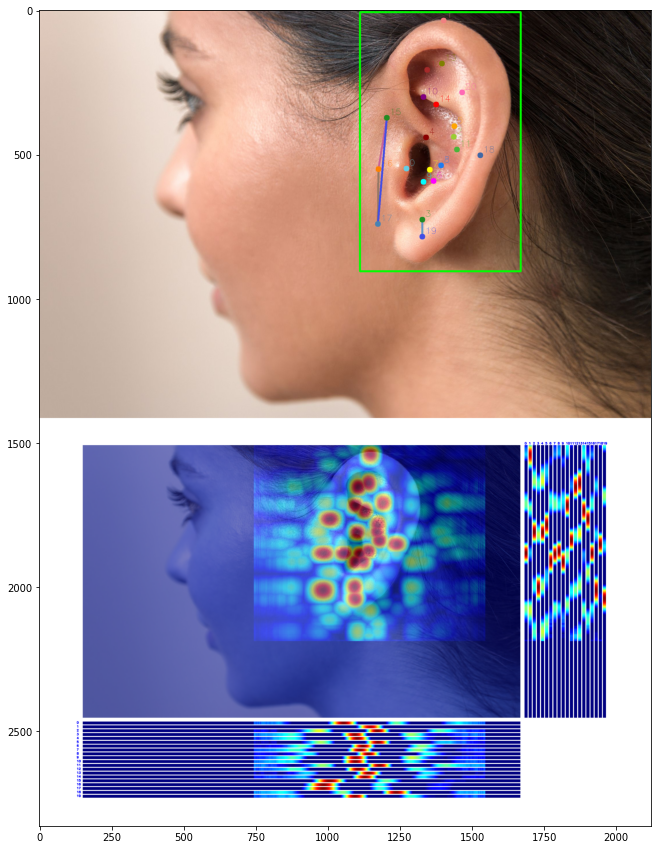

In [38]:
plt.figure(figsize=(15, 15))
plt.imshow(img_output)
plt.show()

## 视频预测

In [ ]:
!python demo/topdown_demo_with_mmdet.py \
        data/rtmdet_tiny_ear.py \
        checkpoint/rtmdet_tiny_ear_epoch_200_20230604-0fba1521.pth \
        data/rtmpose-s-ear.py \
        checkpoint/rtmpose-s-triangle-300_202300604.pth \
        --input data/demo.mp4 \
        --output-root outputs/G2_Video \
        --device cuda:0 \
        --bbox-thr 0.5 \
        --kpt-thr 0.5 \
        --nms-thr 0.3 \
        --radius 16 \
        --thickness 10 \
        --draw-bbox \
        --draw-heatmap \
        --show-kpt-idx